# Classification (1) – an issue with distance measures, and an implementation of Nearest Neighbour classification

## Introduction

In this notebook we will expand on some of the concepts of 
classification, starting with an experiment with distance measures on data, then looking into the $k$-Nearest Neighbour algorithm. 

## 1) Distance measures for high-dimensionality data

Algorithms such as $k$-Nearest Neighbour are conceptually very simple -- we predict the class value of an unlabelled *query* data point we are given by looking at all the labelled data point(s) in our data set, and predicting that our query will have the same class as the most similar data point(s) in the training set. So, all we need is a way of measuring similarity. The well-known *Euclidean distance measure* would seem to be a good choice. However, while we are very familiar with Euclidean distance in 2 and 3-dimensions, there was a warning (Slide 62 of the "Classification (1)" lecture) that in high-dimensions there is a problem – what was this problem ? 

### Pairwise distances in high-dimensional spaces 

**Answer**: in high-dimensional spaces everything is far away from everything else, and so pairwise distances become uninformative.

But what does this actually mean ? There is a mathematical argument to show that this is a true statement, but an alternative approach is simply to simulate what happens. One approach is to randomly generate $N$ points inside a $d$-dimensional cube centred around zero, such as $[-0.5, 0.5]^{d}$. Now we calculate the pairwise distances among the $N$ points.  After that for every data point we calculate the ratio of the minimum distance to the maximum distance  to all of the other data points. The mean ratio represents the average range of pairwise distances there are in that dimensionality. We run the simulation from 1 dimension to 1000 dimensions and the ratios will be plotted on a line chart using the ``` matplotlib ``` library. 

You should use the ```numpy``` library for this, and in particular the linear algebra methods to calculate distances such as the [L2 norm](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm). 

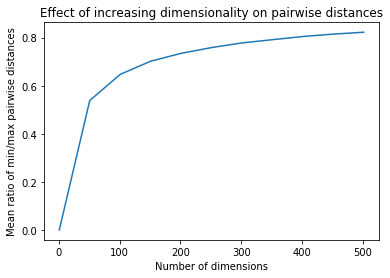

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def run_d_n(dim,N_pts,L):
    pts=np.random.rand(N_pts,dim)-0.5 # simulate N_pts points on dim dimensions space
    ratio_list=[]
    for i in range(N_pts):
        # ignore the data point itself
        selected_pts=np.array([j for j in range(N_pts) if j!=i])
        # calculate the L2 or L1 distance with other points
        dist=np.linalg.norm(pts[selected_pts]-pts[i],L,axis=1)
        # calculate the ratio of the min. distance to the max. distance
        ratio=np.min(dist)/np.max(dist)
        ratio_list.append(ratio)
    # output the mean ratio
    return np.mean(ratio_list)

# Initialise the N_pts, the number of points we simulate
N_pts=1000
# Setting l=2 to calculate the L2 distance
l=1
# Setting the number of dimensions we simulate
check_dim=range(1,550,50)
# Calculate the mean ratio on that dimension
ratio_list=[ run_d_n(dim,N_pts,l) for dim in check_dim]
# Plot the ratio with its corresponding dimension
plt.plot(check_dim,ratio_list)
plt.ylabel("Mean ratio of min/max pairwise distances")
plt.xlabel("Number of dimensions")
plt.title("Effect of increasing dimensionality on pairwise distances")
plt.xticks(np.arange(0, 600, step=100))
plt.show()

**Question:** how can this plot be interpreted ? How else could you visualize this effect ?

We can interpret this as showing that as dimensionality increases the min. and max. distances from any point to any other point become more similar. Something this plot doesn't show is the  distribution of the actual distances. To see this you could try plotting histograms of the distribution of all pairwise distances for a set of points of low, then higher dimensionality. If you do this, first think about how you would expect it to look.

## 2) Implement Nearest Neighbour from scratch

The following will give some practise in implementing a simple classifier, the $k$-Nearest Neighbour ($k$NN) algorithm. It should help us to write a $k$NN package from scratch. Most machine learning methods include two main steps, namely training (fitting to a model to the training data) and prediction (running the model on input data  to generate output). However, in the $k$NN algorithm, since there is no explicit model-building step, we only require implementation of the prediction step without a training step.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data Creation

In [5]:
mean_01 = np.array([1, 0.5])
cov_01 = np.array([[1, 0.1], [0.1, 1.2]])

mean_02 = np.array([4, 5])
cov_02 = np.array([[1, 0.1], [0.1, 1.2]])

dist_01 = np.random.multivariate_normal(mean_01, cov_01, 500)
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 500)
print(dist_01.shape, dist_02.shape)

(500, 2) (500, 2)


We have created two 2-dimensional normal distributions of data points with the same covariance but different means.

## Plotting the created Data 

What does the data look like ? Notice the 2 unique clusters being formed.

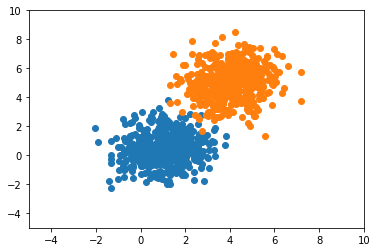

In [6]:
plt.figure(0)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.scatter(dist_01[:, 0], dist_01[:, 1])
plt.scatter(dist_02[:, 0], dist_02[:, 1])#, color='red')
plt.show()

Let us now represent it in a tabular way. We will have dist_01 getting label 1.

In [7]:
r = dist_01.shape[0] + dist_02.shape[0]
c = dist_01.shape[1] + 1
data = np.zeros((r, c))
print(data.shape)

data[:dist_01.shape[0], :2] = dist_01
data[dist_01.shape[0]:, :2] = dist_02
data[dist_01.shape[0]:, -1] = 1.0

print(data.mean(axis=0))

(1000, 3)
[2.50918933 2.74533146 0.5       ]


Now shuffle the data and check by printing the first 10 rows.

In [8]:
np.random.shuffle(data)
print(data[:10])

[[ 1.43602708  0.02318924  0.        ]
 [-0.38240338 -1.07757467  0.        ]
 [ 1.33730568  0.95211793  0.        ]
 [ 4.43283788  6.31322569  1.        ]
 [ 3.27761988  3.16691938  1.        ]
 [ 2.80657734  5.23697968  1.        ]
 [ 4.39933008  5.71520439  1.        ]
 [ 1.19129541 -1.98874709  0.        ]
 [ 4.25999868  6.72193642  1.        ]
 [ 5.01245706  4.81527775  1.        ]]


**Implementation.** Next, we implement our KNN algorithm. There are many ways to do this, but a basic approach will require a pairwise distance measure for instances, and a way to take a "training" dataset of classified instances and make a prediction for a "test" data instance. Here is a top-level outline:

In [9]:
def distance(x1, x2):
    d = np.sqrt(((x1-x2)**2).sum())
    return d

def knn(X_train, y_train, xt, k=7):
    vals = []
    for ix in range(X_train.shape[0]):
        d = distance(X_train[ix], xt)
        vals.append([d, y_train[ix]])
    sorted_labels = sorted(vals, key=lambda z: z[0])
    neighbours = np.asarray(sorted_labels)[:k, -1]
    
    freq = np.unique(neighbours, return_counts=True)
    
    return freq[0][freq[1].argmax()]

In [12]:
np.unique([0,0,0,0,0,1], return_counts=True)

(array([0, 1]), array([5, 1]))

Now check to see if we can make a prediction.

In [10]:
test_point = np.array([8, -4])

# Un-comment the line below and check if it comes out as 0.0  
print(knn(data[:, :2], data[:, -1], test_point))

0.0


## Create a train and test split of the data

In [9]:
np.random.shuffle(data)
split = int(0.75 * data.shape[0])
# print split
train_data_X = data[:split, :2]
train_data_y = data[:split, -1]
test_data_X = data[split:, :2]
test_data_y = data[split:, -1]

print(train_data_X.shape, train_data_y.shape)
print(test_data_X.shape, test_data_y.shape)

(750, 2) (750,)
(250, 2) (250,)


**Implementation.** Next we need to implement some way to run our KNN classifier on all the test data and get the results. 

In [10]:
def get_acc(kx):
    preds = []
    # print kx
    for ix in range(test_data_X.shape[0]):
        preds.append(knn(train_data_X, train_data_y, test_data_X[ix], k=kx))
    preds = np.asarray(preds)
    
    # print preds.shape
    return 100*float((test_data_y == preds).sum())/preds.shape[0]

print(get_acc(7))

99.6


What accuracy did you get ? You should get around 99 percent on this dataset. 

Let's try different values of K.

In [11]:
for ix in range(2, 20):
    print ("k:", ix, "| Acc:", get_acc(ix))

k: 2 | Acc: 99.2
k: 3 | Acc: 99.6
k: 4 | Acc: 99.6
k: 5 | Acc: 99.6
k: 6 | Acc: 99.6
k: 7 | Acc: 99.6
k: 8 | Acc: 99.6
k: 9 | Acc: 99.6
k: 10 | Acc: 99.2
k: 11 | Acc: 99.2
k: 12 | Acc: 99.2
k: 13 | Acc: 99.2
k: 14 | Acc: 99.2
k: 15 | Acc: 99.2
k: 16 | Acc: 99.2
k: 17 | Acc: 99.2
k: 18 | Acc: 99.2
k: 19 | Acc: 99.2


## Now let's try real data : MNIST

In [12]:
import pandas as pd
import datetime

Of course, MNIST is image data, but here we are using a CSV version where we can view the pixels as numbers (each row has the pixel data for an image of a digit, and the first column is the class of the digit, i.e., 0-9).

In [13]:
df = pd.read_csv('train.csv')
df.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the dataset is quite big, we will just use a subset.

In [14]:
data = df.values[:2000]
print (data.shape)

(2000, 785)


Make a train/test split of the data.

In [15]:
split = int(0.8 * data.shape[0])

X_train = data[:split, 1:]
X_test = data[split:, 1:]

y_train = data[:split, 0]
y_test = data[split:, 0]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1600, 784) (1600,)
(400, 784) (400,)


Let us just check that our data really does represent images.

4


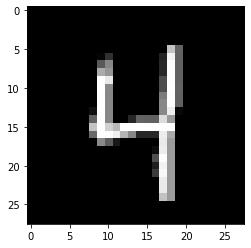

In [16]:
plt.figure(0)
plt.imshow(X_train[91].reshape((28, 28)), cmap='gray', interpolation='none')
print (y_train[91])
plt.show()

**Implementation.** Now code another ```get_acc()``` and try different values of K on our dataset.

In [18]:
def get_acc(kx):
    preds = []
    # print kx
    for ix in range(X_test.shape[0]):
        start = datetime.datetime.now()
        preds.append(knn(X_train, y_train, X_test[ix], k=kx))
        print("Test point: ", str(ix), " runtime: ", str(datetime.datetime.now() - start))
        # print(ix)
        # print(datetime.datetime.now() - start)
    preds = np.asarray(preds)
    
    # print preds.shape
    return 100*float((y_test == preds).sum())/preds.shape[0]

print("Result: ")
print(get_acc(5))  # k=5 nearest neighbours
#print(get_acc(20))  # k=20 nearest neighbours

Result: 
Test point:  0  runtime:  0:00:00.037033
Test point:  1  runtime:  0:00:00.037368
Test point:  2  runtime:  0:00:00.034837
Test point:  3  runtime:  0:00:00.035201
Test point:  4  runtime:  0:00:00.034959
Test point:  5  runtime:  0:00:00.036855
Test point:  6  runtime:  0:00:00.036235
Test point:  7  runtime:  0:00:00.034796
Test point:  8  runtime:  0:00:00.034966
Test point:  9  runtime:  0:00:00.035075
Test point:  10  runtime:  0:00:00.035145
Test point:  11  runtime:  0:00:00.037586
Test point:  12  runtime:  0:00:00.036456
Test point:  13  runtime:  0:00:00.033439
Test point:  14  runtime:  0:00:00.035247
Test point:  15  runtime:  0:00:00.034223
Test point:  16  runtime:  0:00:00.030571
Test point:  17  runtime:  0:00:00.030966
Test point:  18  runtime:  0:00:00.031794
Test point:  19  runtime:  0:00:00.030556
Test point:  20  runtime:  0:00:00.030231
Test point:  21  runtime:  0:00:00.030700
Test point:  22  runtime:  0:00:00.030648
Test point:  23  runtime:  0:00:00.

Test point:  198  runtime:  0:00:00.032587
Test point:  199  runtime:  0:00:00.032510
Test point:  200  runtime:  0:00:00.032396
Test point:  201  runtime:  0:00:00.031641
Test point:  202  runtime:  0:00:00.032494
Test point:  203  runtime:  0:00:00.030829
Test point:  204  runtime:  0:00:00.033005
Test point:  205  runtime:  0:00:00.033540
Test point:  206  runtime:  0:00:00.031949
Test point:  207  runtime:  0:00:00.031970
Test point:  208  runtime:  0:00:00.032089
Test point:  209  runtime:  0:00:00.032722
Test point:  210  runtime:  0:00:00.031946
Test point:  211  runtime:  0:00:00.032337
Test point:  212  runtime:  0:00:00.032343
Test point:  213  runtime:  0:00:00.031723
Test point:  214  runtime:  0:00:00.031870
Test point:  215  runtime:  0:00:00.031755
Test point:  216  runtime:  0:00:00.031105
Test point:  217  runtime:  0:00:00.031046
Test point:  218  runtime:  0:00:00.031956
Test point:  219  runtime:  0:00:00.032613
Test point:  220  runtime:  0:00:00.033660
Test point:

Test point:  393  runtime:  0:00:00.033062
Test point:  394  runtime:  0:00:00.031028
Test point:  395  runtime:  0:00:00.031993
Test point:  396  runtime:  0:00:00.031793
Test point:  397  runtime:  0:00:00.031854
Test point:  398  runtime:  0:00:00.032736
Test point:  399  runtime:  0:00:00.033146
89.25


In [13]:
neighbours = [0,0,0,0,1]

In [15]:
freq = np.unique(neighbours, return_counts=True)[1]

In [20]:
freq.argmax()

0

In [21]:
x = np.array([1,2,3,4,5, 6,7])
y = np.array([2,2,5,5,5, 5,7])


In [27]:
np.sqrt(((x-y)**2).sum())

2.6457513110645907

In [28]:
def distance(x,y,p):
    return (((x-y)**p).sum())^(1/p)